# Explore CCODWG Data Set

+ The [COVID-19 Canadian Open Data Working Group (CCODWG)](https://opencovid.ca/) supports an [API](https://opencovid.ca/api/) for accessing time series data on the pandemic.
+ **Goal:** Access the data through this API using Jupyter
+ Plot covid case counts across provinces

## Access the data

In [1]:
import requests

In [2]:
# CCODWG uses DD-MM-YYYY date format
# https://api.opencovid.ca/timeseries?stat=cases&loc=3595&after=01-03-2020&before=05-03-2020
# https://api.opencovid.ca/timeseries?stat=cases&loc=3595&dater=01-03-2020
response = requests.get('https://api.opencovid.ca/timeseries?stat=cases&loc=prov&after=01-01-2021').json()

In [ ]:
#response

That was straightforward! 

The contents of response is a JSON file that looks like a list of time series reports:
```
    {'cases': 
     [{'cases': 1519,
       'cumulative_cases': 283710,
       'date_report': '21-09-2021',
       'province': 'Alberta'},
      {'cases': 1336,
       'cumulative_cases': 285046,
       'date_report': '22-09-2021',
       'province': 'Alberta'},
               ...
```
I want to reshape this into a pandas dataframe that resembles this form

|   | cases  | cumulative_cases  | date_report  |  provice |
|---|---|---|---|---|
|  0 | blah  |  blah |  blah |  blah |


## Reshape the data

In [3]:
# convert the time series JSON into a python list of the desired form
table = []
for entry in response['cases']:
    table.append([entry['cases'],entry['cumulative_cases'],entry['date_report'],entry['province']])
# print(table)

In [ ]:
table

In [5]:
# import pandas to convert the list table into a dataframe.
import pandas as pd

In [6]:
# convert the list into a pandas dataframe with the desired column headings
df = pd.DataFrame(table, columns=["cases", "cumulative_cases", "date_report", "province"])

In [7]:
df.head(n=4)

,cases,cumulative_cases,date_report,province
0,0,100428,01-01-2021,Alberta
1,0,100428,02-01-2021,Alberta
2,0,100428,03-01-2021,Alberta
3,5107,105535,04-01-2021,Alberta


In [8]:
len(df)

3766

Yay! I can read in the CCODWG data stream using the opencovid API and have shaped into the desired form.

## Convert date strings to timestamps

In [9]:
type(df['date_report'][1])

str

In [10]:
# Convert the strings entered in the 'date_report' column into timestamps
df['date_report'] = pd.to_datetime(df['date_report'], format="%d-%m-%Y")

In [11]:
type(df['date_report'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
df.head(n=4)

,cases,cumulative_cases,date_report,province
0,0,100428,2021-01-01,Alberta
1,0,100428,2021-01-02,Alberta
2,0,100428,2021-01-03,Alberta
3,5107,105535,2021-01-04,Alberta


## Visualize the data

In [ ]:
### Add some tools

In [13]:
### tools for manipulated timestamps
### which of these are actually needed here?
from datetime import *
from dateutil.relativedelta import *
import calendar
from dateutil.rrule import *
from dateutil.parser import *


In [14]:
import matplotlib.pyplot as plt 

In [15]:
%matplotlib inline

## Plot cases vs. time grouped by provinces aggregated over `freq`

<AxesSubplot:title={'center':'some title'}, xlabel='date_report'>

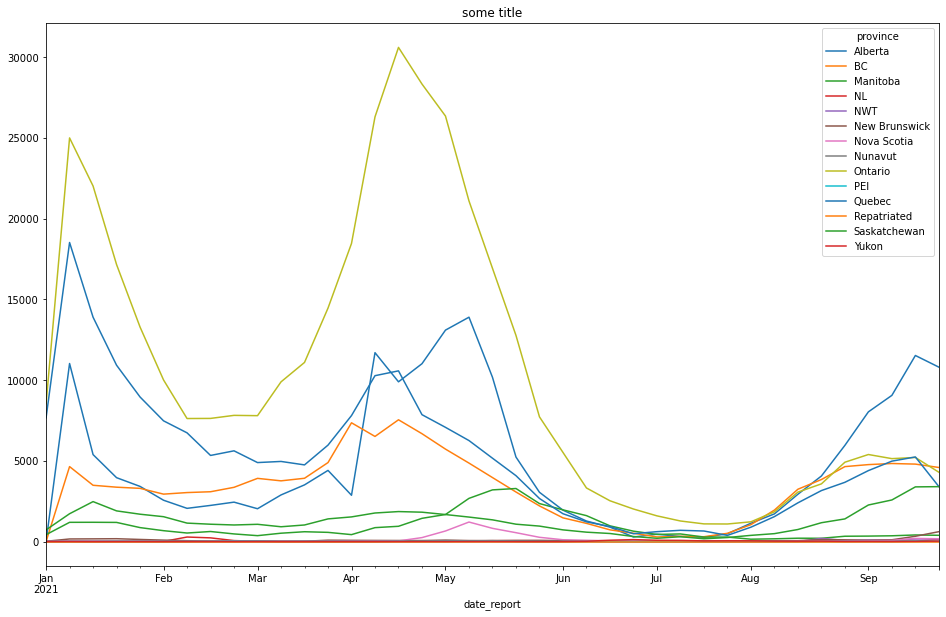

In [16]:
df.groupby([pd.Grouper(key='date_report', 
                       freq='W'),'province']).sum().unstack().plot(kind='line',
                                                                    y='cases', 
                                                                    title= "some title",
                                                                    figsize = (16,10))

## Plot covid cases for Canada in stacked bars for each province aggregated over `freq`

<AxesSubplot:title={'center':'some title'}, xlabel='date_report'>

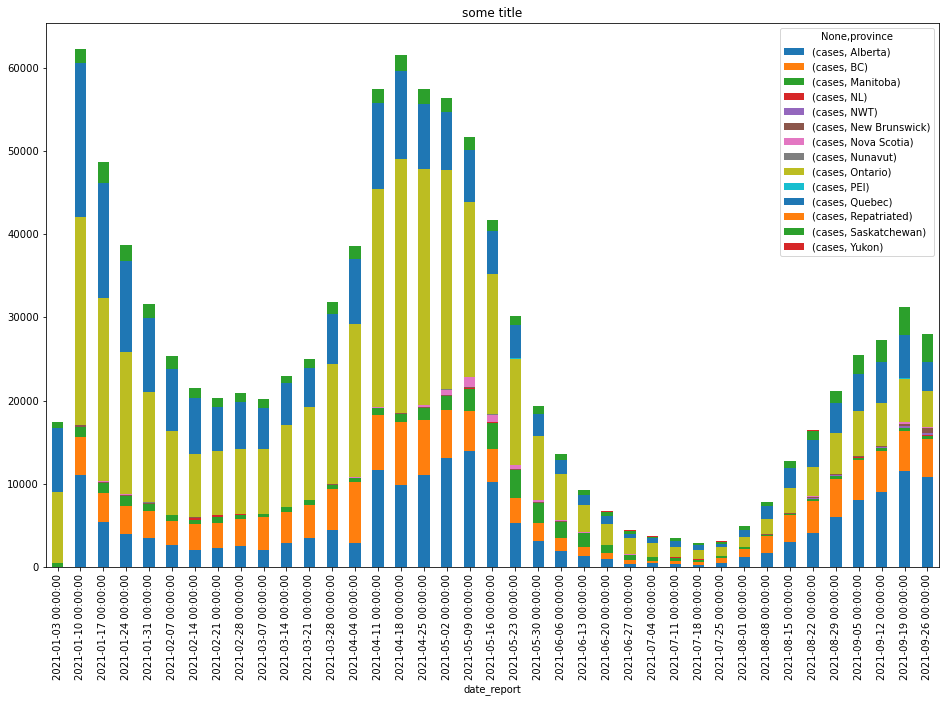

In [17]:
pd.pivot_table(df,index=[pd.Grouper(key='date_report', freq='W'),'province'], 
               aggfunc = sum, values = ['cases']).head(n=2000).unstack().plot(
                kind='bar', title= "some title", figsize=(16,10), stacked=True )

## Explore prov endpoint; Population normalization

In [ ]:
prov_info = requests.get('https://api.opencovid.ca/other?stat=prov').json()

In [ ]:
prov_info

In [ ]:
population = {}
for entry in prov_info['prov']:
    population[entry['province']] = entry['pop']

In [ ]:
population['BC']

In [ ]:
df.head(n=3)

In [ ]:
def normalize(x,y):
    return x * 100000 / population[y]

In [ ]:
normalize(df['cases'][78],df['province'][78])

In [ ]:
df['cases'][78],df['province'][78]

In [ ]:
556 * 100000 / population['Alberta']

In [ ]:
type(df)

In [ ]:
df

In [ ]:
# gapminder_df['pop']= gapminder_df['continent'].map(pop_dict)
df['casesper100k'] = 100000 * df['cases'] / df['pop']

In [ ]:
df['pop'] = df['province'].map(population)

In [ ]:
df = df.loc[~(df['pop'] == 'NULL')]

In [ ]:
df['pop'].unique()

In [ ]:
df

In [ ]:
df

In [ ]:
df['casesper100k'].plot()

In [ ]:
pd.pivot_table(df,index=[pd.Grouper(key='date_report', freq='W'),'province'], 
               aggfunc = sum, values = ['cases']).head(n=2000).unstack().plot(
                kind='bar', title= "some title", figsize=(16,10), stacked=True )

In [ ]:
df

In [ ]:
type(df['casesper100k'])

In [ ]:
df['casesper100k'] = df['casesper100k'].astype('int64')

In [ ]:
df.groupby([pd.Grouper(key='date_report', 
                       freq='W'),'province']).sum().unstack().plot(kind='line',
                                                                    y='casesper100k', 
                                                                    title= "some title",
                                                                    figsize = (16,10))

In [ ]:
pd.pivot_table(df,index=[pd.Grouper(key='date_report', freq='W'),'province'], 
               aggfunc = sum, values = ['casesper100k']).head(n=2000).unstack().plot(
                kind='bar', title= "some title", figsize=(16,10), stacked=True )